## Предобработка данных

Импортируем данные

In [43]:
# Импортируем данные
import pandas as pd
from import_dat import column_names, unclaimed_columns

df = pd.read_csv('4fgl_full.dat', 
                sep='\s+', 
                header=None,
                index_col=0,
                names=column_names,
                )

Проверяем, сколько различных типов объектов

In [44]:
from import_dat import *
for i in df['source_type'].unique():
    print(i, ' — ', source_classes[i])

bcu  —  Blazar candidate of uncertain type
unk  —  Unknown
bll  —  BL Lac type of blazar
fsrq  —  FSRQ type of blazar
MSP  —  Millisecond pulsar
lmb  —  Low-mass binary
FSRQ  —  FSRQ type of blazar
GAL  —  Normal galaxy (or part)
rdg  —  Radio galaxy
sfr  —  Star-forming region
glc  —  Globular cluster
snr  —  Supernova remnant
PSR  —  Pulsar, identified by pulsations
pwn  —  Pulsar wind nebula
msp  —  Millisecond pulsar
HMB  —  High-mass binary
LMB  —  Low-mass binary
sey  —  Seyfert galaxy
PWN  —  Pulsar wind nebula
spp  —  Supernova remnant / Pulsar wind nebula
SNR  —  Supernova remnant
SPP  —  Supernova remnant / Pulsar wind nebula
psr  —  Pulsar, no pulsations seen in LAT yet
gal  —  Normal galaxy (or part)
BIN  —  Binary
NOV  —  Nova
SFR  —  Star-forming region
bin  —  Binary
sbg  —  Starburst galaxy
BLL  —  BL Lac type of blazar
nlsy1  —  Narrow-line Seyfert 1
RDG  —  Radio galaxy
AGN  —  Non-blazar active galaxy
agn  —  Non-blazar active galaxy
hmb  —  High-mass binary
GC  —  G

Отсеиваем только блазары и квазары, а также `unknown`. Остальные типы помечаем как `other`

In [45]:
from utility import normalize_source_type
df_processed = normalize_source_type(df)
df_processed['source_type'].value_counts()

blazar     3934
unknown    2577
other       543
pulsar      141
Name: source_type, dtype: int64

Разделяем выборку на известные и неизвестные типы

In [46]:
df_known = df_processed[df_processed['source_type'] != 'unknown'].copy()
df_unknown = df_processed[df_processed['source_type'] == 'unknown'].copy()

Вместо исходных классов делаем dummy variables для df_known

In [47]:
df_dummies = pd.get_dummies(df_known, columns=['source_type'], prefix='source')
df_dummies.head()

,ra,dec,flux_1_100_gev,flux_1_100_gev_error,detection_significance,semi_major_axis_68,semi_minor_axis_68,position_angle_68,semi_major_axis_95,semi_minor_axis_95,...,npred,variability_index,frac_variability,frac_variability_error,significance_peak,flux_peak,flux_peak_error,source_blazar,source_other,source_pulsar
name,,,,,,,,,,,,,,,,,,,,,
J0908.5-8751,137.150,-86.1339,1.166700e-10,2.546200e-11,6.2932,0.0929,0.0782,-14.12,0.1506,0.1268,...,830.55,28.699499,0.4840,0.1895,6.247304,2.386100e-08,4.128800e-09,1,0,0
J1354.1-8750,208.545,-86.1603,1.298300e-10,2.774600e-11,4.5903,0.0626,0.0607,-71.19,0.1015,0.0984,...,473.70,8.378150,0.0000,10.0000,0.000000,0.000000e+00,0.000000e+00,1,0,0
J2109.8-8618,317.462,-85.6922,2.953600e-10,3.429700e-11,16.7126,0.0236,0.0175,79.28,0.0382,0.0284,...,411.17,19.224632,0.2585,0.1825,0.000000,0.000000e+00,0.000000e+00,1,0,0
J1027.0-8542,156.765,-84.2836,1.082000e-09,5.312100e-11,39.3804,0.0113,0.0107,-51.78,0.0184,0.0173,...,1242.32,8.896601,0.0000,10.0000,0.000000,0.000000e+00,0.000000e+00,1,0,0
J0931.2-8533,142.818,-84.4375,3.765200e-10,3.764600e-11,13.3109,0.0361,0.0318,6.40,0.0586,0.0516,...,1232.80,77.880920,0.7432,0.1713,10.234067,3.113400e-08,3.735300e-09,1,0,0


Разделяем выборку на тренировочную и тестовую

In [48]:
from sklearn.model_selection import train_test_split

# Разбиваем данные на train и test выборки
data_train, data_test = train_test_split(df_dummies, test_size=0.2)

In [49]:
data_train.shape

(3694, 48)

Аугментируем тренировочные данные с помощью гауссового шума на основе ошибок 

In [50]:
from utility import augmentation

data_train_aug = augmentation(data_train, error_columns=unclaimed_columns, times = 5)

In [51]:
data_train_aug.shape

(22164, 48)

Делим переменные на параметры и target

In [52]:
# Выделяем target-переменные
target_columns = ['source_blazar','source_other','source_pulsar']

# Выделяем target-переменные
X_train = data_train_aug.drop(target_columns, axis=1)
y_train = data_train_aug[target_columns]

# Аналогично — выделяем в тестовой выборке
X_test = data_test.drop(target_columns, axis=1)
y_test = data_test[target_columns]

In [53]:
print(f"Размерность X_train: {X_train.shape}")
print(f"Размерность y_train: {y_train.shape}")
print(f"Размерность X_test: {X_test.shape}")
print(f"Размерность y_test: {y_test.shape}")

Размерность X_train: (22164, 45)
Размерность y_train: (22164, 3)
Размерность X_test: (924, 45)
Размерность y_test: (924, 3)


Избавляемся от самих столбцов с ошибками

In [54]:
X_train = X_train.drop(unclaimed_columns, axis=1).reset_index(drop=True)
X_test = X_test.drop(unclaimed_columns, axis=1).reset_index(drop=True)
df_unknown = df_unknown.drop(unclaimed_columns, axis=1).reset_index(drop=True)

Нормируем данные

In [55]:
from sklearn.preprocessing import RobustScaler
from utility import normalize_df

# Инициализируем скейлер и 'обучаем' его на наших данных
scaler = RobustScaler()
scaled_data = scaler.fit(X_train.select_dtypes(include='number'))

# Нормируем данные с одним и тем же скейлером
X_train = normalize_df(X_train, scaler)
X_test = normalize_df(X_test, scaler)
df_unknown = normalize_df(df_unknown, scaler)

## Обучение нейросети

### Построение архитектуры

Создаём экземпляр нейронной сети

In [58]:
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras import regularizers

# Построение модели нейронной сети
model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='leaky_relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

# Компиляция модели
model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

#### Обучение модели

Задаём веса отдельным классам для компенсации их диспропорции

In [59]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', 
                                     classes = np.unique(df_known['source_type']), 
                                     y = df_known['source_type']
                                     )

class_weight_dict = dict(enumerate(class_weights))

Обучаем модель с полученными весами

Epoch 1/50
222/222 [==============================] - 1s 3ms/step - loss: 66.1326 - accuracy: 0.4657 - val_loss: 1.7841 - val_accuracy: 0.7576
Epoch 2/50
222/222 [==============================] - 0s 2ms/step - loss: 23.2600 - accuracy: 0.7075 - val_loss: 1.7032 - val_accuracy: 0.8052
Epoch 3/50
222/222 [==============================] - 0s 2ms/step - loss: 27.1359 - accuracy: 0.7442 - val_loss: 3.9027 - val_accuracy: 0.8323
Epoch 4/50
222/222 [==============================] - 0s 2ms/step - loss: 27.1388 - accuracy: 0.7728 - val_loss: 6.3363 - val_accuracy: 0.8344
Epoch 5/50
222/222 [==============================] - 0s 2ms/step - loss: 14.1546 - accuracy: 0.7674 - val_loss: 6.8081 - val_accuracy: 0.8149
Epoch 6/50
222/222 [==============================] - 1s 2ms/step - loss: 25.7644 - accuracy: 0.7651 - val_loss: 7.8995 - val_accuracy: 0.8409
Epoch 7/50
222/222 [==============================] - 0s 2ms/step - loss: 14.3557 - accuracy: 0.7664 - val_loss: 4.1791 - val_accuracy: 0.8193

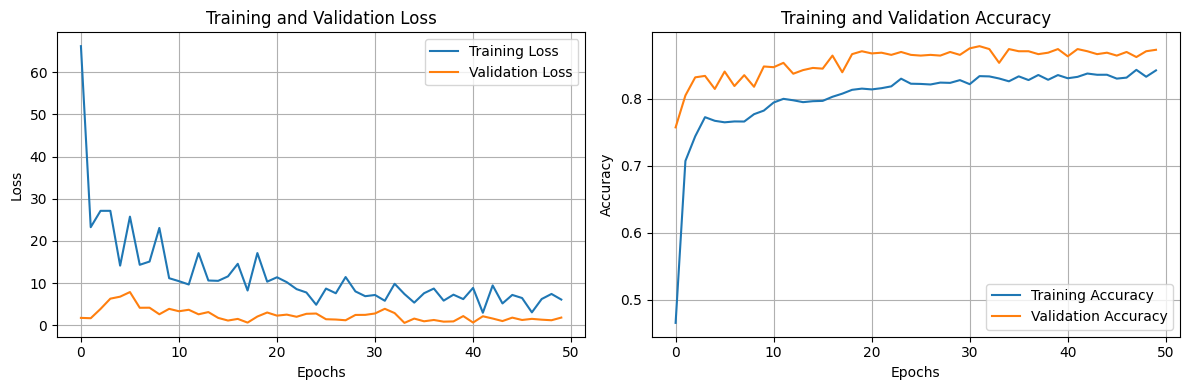

In [60]:
from utility import visualize_training_history

history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=100, 
                    validation_data=(X_test, y_test), 
                    class_weight=class_weight_dict
                    )

visualize_training_history(history)

Классификация неизвестных источников

In [61]:
X_validation = df_unknown.drop(['source_type'], axis=1)
predictions = model.predict(X_validation)

81/81 [==============================] - 0s 2ms/step


In [62]:
from utility import combine_predictions

df_predicted = df_unknown.copy()

df_predicted[['blazar', 'other', 'pulsar']] = predictions
df_predicted['predicted_class'] = combine_predictions(predictions, threshold=0, ratio_threshold=1)

# Выводим на экран результаты
df_predicted#[df_predicted['predicted_class'] == 2]

,source_type,ra,dec,flux_1_100_gev,detection_significance,semi_major_axis_68,semi_minor_axis_68,position_angle_68,semi_major_axis_95,semi_minor_axis_95,...,plec_epeak,npred,variability_index,frac_variability,significance_peak,flux_peak,blazar,other,pulsar,predicted_class
0,unknown,-0.584204,-1.371826,0.302846,0.540808,-0.178273,-0.241509,0.698861,-0.178694,-0.238979,...,0.282792,0.317796,0.093070,-0.191794,0.0,0.0,0.729640,0.251061,0.019299,0
1,unknown,0.681429,-1.378163,-0.414058,-0.354588,-0.047354,0.018868,-0.542759,-0.048110,0.020882,...,3.733413,-0.588744,-0.069902,-0.574502,0.0,0.0,0.658241,0.330164,0.011595,0
2,unknown,0.120975,-1.382450,-0.382036,-0.565300,0.529248,0.720755,-0.809196,0.527491,0.719258,...,-0.072209,-0.199580,-0.103836,-0.574502,0.0,0.0,0.690535,0.239427,0.070038,0
3,unknown,-0.715198,-1.364445,-0.091923,-0.178468,1.122563,0.516981,-0.229050,1.120275,0.517401,...,0.198664,-0.235315,-0.285625,-0.574502,0.0,0.0,0.505852,0.438114,0.056034,0
4,unknown,0.976654,-1.328006,-0.267810,-0.291426,-0.181058,-0.154717,0.406747,-0.182131,-0.153132,...,0.513505,-0.346954,-0.199774,-0.574502,0.0,0.0,0.689862,0.292504,0.017635,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,unknown,-0.903537,1.274900,-0.294385,-0.327779,0.573816,0.200000,-0.549635,0.573883,0.199536,...,0.951178,-0.342572,0.025696,-0.162986,0.0,0.0,0.845627,0.150457,0.003916,0
2573,unknown,-0.034726,1.294590,-0.298271,-0.294883,1.047354,0.856604,-0.052643,1.046392,0.853828,...,-0.072209,0.000606,-0.198713,-0.328270,0.0,0.0,0.711203,0.246405,0.042392,0
2574,unknown,0.940963,1.299493,-0.320709,-0.457952,2.300836,2.056604,0.251289,2.298969,2.051044,...,0.032571,-0.152539,-0.332960,-0.574502,0.0,0.0,0.178058,0.667095,0.154847,1
2575,unknown,-1.049994,1.320320,-0.380174,-0.519709,1.272981,1.558491,-0.582510,1.271478,1.556845,...,0.286078,-0.338446,-0.209447,-0.574502,0.0,0.0,0.762617,0.223421,0.013962,0
